* https://nixtlaverse.nixtla.io/statsforecast/docs/how-to-guides/generating_features.html
* https://nixtlaverse.nixtla.io/mlforecast/docs/how-to-guides/transforming_exog.html
* https://nixtlaverse.nixtla.io/utilsforecast/feature_engineering.html#fourier

In [2]:
import pandas as pd

# forecast & feature engine
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from utilsforecast.feature_engineering import fourier
# data
from mlforecast.utils import generate_daily_series, generate_prices_for_series
# util
from utilsforecast.plotting import plot_series
# model
from sklearn.linear_model import LinearRegression

# data

## 生成模拟数据

In [27]:
series = generate_daily_series(
    n_series=4,
    # max_length=300,
    equal_ends=True,
    n_static_features=2,
    static_as_categorical=False,
    with_trend = True,
).rename(columns = {"static_1": "product_id"})
print(series.head())
print()
print(series.tail())
print()
print(series.shape)
print()
print(series["unique_id"].value_counts())

  unique_id         ds         y  static_0  product_id
0      id_0 2000-10-05  0.602763         1          44
1      id_0 2000-10-06  2.745399         1          44
2      id_0 2000-10-07  4.824687         1          44
3      id_0 2000-10-08  7.247442         1          44
4      id_0 2000-10-09  9.239651         1          44

    unique_id         ds           y  static_0  product_id
723      id_3 2001-05-10  284.821659        33          77
724      id_3 2001-05-11  316.484522        33          77
725      id_3 2001-05-12  356.377963        33          77
726      id_3 2001-05-13  387.352690        33          77
727      id_3 2001-05-14  415.494000        33          77

(728, 5)

unique_id
id_3    242
id_0    222
id_2    167
id_1     97
Name: count, dtype: int64


## 添加傅里叶项模拟季节性

In [28]:
transformed_df, future_df = fourier(
    series, 
    freq = "D", 
    season_length = 7, 
    k = 2, 
    h = 7,
)

In [29]:
print(transformed_df.head())
print()
print(transformed_df.tail())
print()
print(transformed_df.shape)
print()
print(transformed_df["unique_id"].value_counts())

  unique_id         ds         y  static_0  product_id        sin1_7   
0      id_0 2000-10-05  0.602763         1          44  4.769952e-08  \
1      id_0 2000-10-06  2.745399         1          44  7.818317e-01   
2      id_0 2000-10-07  4.824687         1          44  9.749277e-01   
3      id_0 2000-10-08  7.247442         1          44  4.338827e-01   
4      id_0 2000-10-09  9.239651         1          44 -4.338834e-01   

         sin2_7    cos1_7    cos2_7  
0  9.539905e-08  1.000000  1.000000  
1  9.749277e-01  0.623489 -0.222522  
2 -4.338851e-01 -0.222522 -0.900968  
3 -7.818301e-01 -0.900969  0.623492  
4  7.818310e-01 -0.900969  0.623490  

    unique_id         ds           y  static_0  product_id    sin1_7   
723      id_3 2001-05-10  284.821659        33          77 -0.000005  \
724      id_3 2001-05-11  316.484522        33          77  0.781829   
725      id_3 2001-05-12  356.377963        33          77  0.974929   
726      id_3 2001-05-13  387.352690        33    

In [30]:
print(future_df.head(10))
print()
print(future_df.tail(10))
print()
print(future_df.shape)
print()
print(future_df["unique_id"].value_counts())

  unique_id         ds    sin1_7    sin2_7    cos1_7    cos2_7
0      id_0 2001-05-15 -0.974927  0.433889 -0.222524 -0.900967
1      id_0 2001-05-16 -0.781833 -0.974927  0.623488 -0.222526
2      id_0 2001-05-17 -0.000002 -0.000004  1.000000  1.000000
3      id_0 2001-05-18  0.781830  0.974929  0.623491 -0.222518
4      id_0 2001-05-19  0.974928 -0.433881 -0.222520 -0.900970
5      id_0 2001-05-20  0.433885 -0.781833 -0.900968  0.623488
6      id_0 2001-05-21 -0.433883  0.781831 -0.900969  0.623491
7      id_1 2001-05-15 -0.974927  0.433889 -0.222524 -0.900967
8      id_1 2001-05-16 -0.781833 -0.974927  0.623488 -0.222526
9      id_1 2001-05-17 -0.000002 -0.000004  1.000000  1.000000

   unique_id         ds    sin1_7    sin2_7    cos1_7    cos2_7
18      id_2 2001-05-19  0.974928 -0.433881 -0.222520 -0.900970
19      id_2 2001-05-20  0.433885 -0.781833 -0.900968  0.623488
20      id_2 2001-05-21 -0.433883  0.781831 -0.900969  0.623491
21      id_3 2001-05-15 -0.974927  0.433889 -0.222

# model training

In [31]:
fcst = MLForecast(
    models = LinearRegression(),
    freq = "D",
)
fcst.fit(transformed_df, static_features = ["static_0", "product_id"])

MLForecast(models=[LinearRegression], freq=D, lag_features=[], date_features=[], num_threads=1)

In [32]:
print(fcst.ts.features_order_)
print(fcst.ts.date_features)
print(fcst.ts.features)
print(fcst.ts.static_features)
print(fcst.ts.target_col)
print(fcst.ts.lag_transforms)
print(fcst.ts.target_transforms)

['static_0', 'product_id', 'sin1_7', 'sin2_7', 'cos1_7', 'cos2_7']
[]
[]
['static_0', 'product_id']
y
{}
None


# model predicting

In [33]:
predicion = fcst.predict(h = 7, X_df = future_df)
print(predicion.head())
print()
print(predicion.shape)
print()
print(predicion["unique_id"].value_counts())

  unique_id         ds  LinearRegression
0      id_0 2001-05-15         14.332445
1      id_0 2001-05-16         13.888583
2      id_0 2001-05-17         52.595941
3      id_0 2001-05-18         42.570927
4      id_0 2001-05-19         17.091006

(28, 3)

unique_id
id_0    7
id_1    7
id_2    7
id_3    7
Name: count, dtype: int64


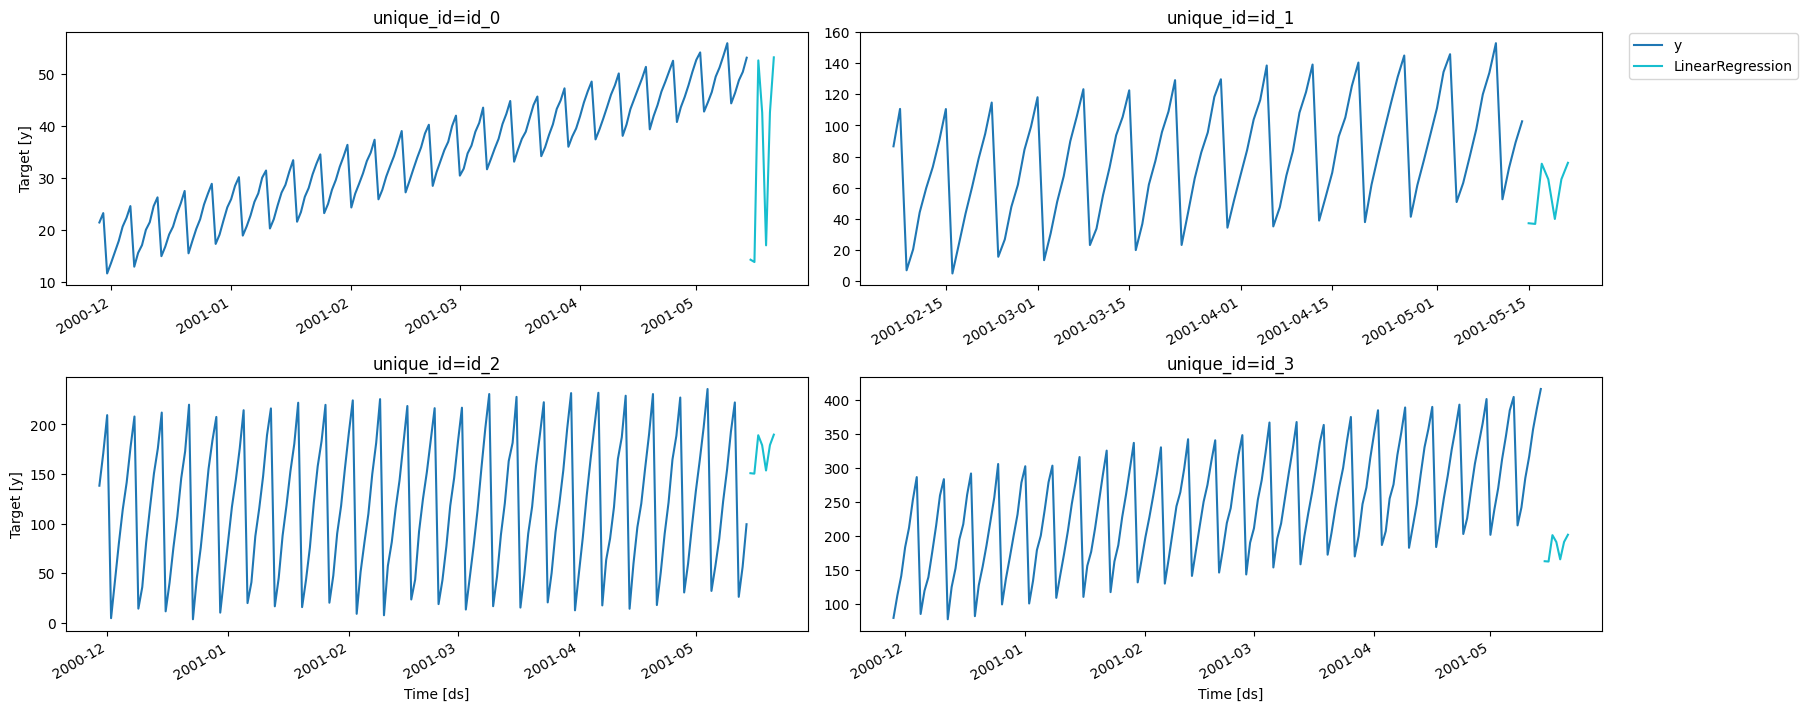

In [34]:
fig = plot_series(transformed_df, predicion, max_insample_length=24*7)
fig